* By: Jacques Joubert
* Email: jacques@quantsportal.com
* Reference: Advances in Financial Machine Learning, Marcos Lopez De Prado, pg 101


# Chapter 6 Ensemble Methods

## Question 1:
**Why is bagging based on random sampling with replacement? Would bagging still reduce a forecast’s variance if sampling were without replacement?**

Sampling without replacement is called Pasting and with replacement is Bagging. Pasting is designed for very large data sets that can afford to make use of sampling without replacement. Both have the same purpose in mind - to create a diverse set of models. These diverse models are then used in an ensemble method which has a similar bias but a lower variance than a single predictor trained on the original training set. One may also observe an increase in bias and a lowering in variance from an ensemble method.

Bagging ends up with a slightly higher bias than pasting which results in the predictors being less correlated (for a small dataset), thus the ensemble's variance is reduced. Overall bagging is preferred as it often leads to better models, however for a large dataset, using Pasting could lead to less correlated predictors because there won’t be any duplicates in the observations.

## Question 2:
**Suppose that your training set is based on highly overlapping labels (i.e., with low uniqueness, as defined in Chapter 4).**

**(a) Does this make bagging prone to overfitting, or just ineffective? Why?**

“Redundant observations have two detrimental effects on bagging. First Samples drawn with replacement are more likely to be virtually identical, even if they do not share the same observations. This makes $\overline{p} \approx 1$, and bagging will not reduce variance, regardless of the number of estimators $N$.” (Advances in Financial Machine Learning, pg 97, 6.3.3 Observation Redundancy)

The advantage of using Bagging lays in its ability to reduce forecast variance and thus prevents overfitting. The variance of the bagged prediction is a function of the number of bagged estimators, the average variance of a single estimator’s prediction, and the average correlation among their forecasts.

Models that are trained on the same type of data are likely to make the same type of errors. When there are many overlapping samples (low uniqueness) then it results in models with poor diversity (high correlation).

Bagging is only effective to the extent that the average correlation among forecasters is less than 1. One of the goals of sequential bootstrapping (Chapter 4) is to produce samples as independent as possible, thereby reducing the avg correlation, which should lower the variance of bagging classifiers.

<div align="center">
  <img src="https://raw.githubusercontent.com/hudson-and-thames/research/master/Chapter6_EnsembleMethods/images/ch6_bagged_prediction.png" width="500"><br>
</div>

The plot above (Advances in Financial Machine Learning, pg 95) shows that models that are highly correlated (overbar p), fail to reduce the variance. It is better to have a few diverse models than a large number of correlated ones.

Thus training models on data that has a low average uniqueness, makes the bagging ensemble more ineffective. It also leads to the out-of-bag accuracy being grossly over-inflated.

**(b) Is out-of-bag accuracy generally reliable in financial applications? Why?**

“The second detrimental effect from observation redundancy is that out-of-bag accuracy will be inflated. This happens because random sampling with replacement places in the training set samples that are very similar to those out-of-bag. In such a case, a proper stratified k-fold cross-validation without shuffling before partitioning will show a much lower testing-set accuracy than the one estimated out-of-bag. For this reason, it is advisable to set StratifiedKFold(n_splits=k, shuffle=False) when using that sklearn class, cross-validate the bagging classifier, and ignore the out-of-bag accuracy results. A low number k is preferred to a high one, as excessive partitioning would again place in the testing set samples too similar to those used in the training set.” (Advances in Financial Machine Learning, pg 97, 6.3.3 Observation Redundancy)


## Question 3:

**Build an ensemble of estimators, where the base estimator is a decision tree.**

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.datasets import load_iris, make_classification
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score 

In [2]:
# Create data
X, y = make_classification(n_samples=2000, n_features=30,
                            n_informative=15, n_redundant=10,
                            random_state=42, shuffle=True)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True, stratify=None)

In [3]:
# Create model
bag_clf = BaggingClassifier(DecisionTreeClassifier(splitter="best", max_leaf_nodes=None),
                            n_estimators=500, max_samples=100, bootstrap=True, n_jobs=-1, oob_score=True)

# Fit and score
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)
y_pred = bag_clf.predict(X_test)

print('Out-of-bag score on training: {}'.format(bag_clf.oob_score_))
print('Test Score: {}'.format(accuracy_score(y_test, y_pred)))

Out-of-bag score on training: 0.8435714285714285
Test Score: 0.85


**(a) How is this ensemble different from an RF?**

A random forest also makes use of a bagging method and thus it has the same hyperparameters as a decision tree and a bagging classifier. However the key difference is that it introduces extra randomness when building trees as it splits the data on the best feature from a random subset of features. This results in greater tree diversity, thus lowering the variance.

**(b) Using sklearn, produce a bagging classifier that behaves like an RF. What parameters did you have to set up, and how?**

First we build a random forest classifier and then we fit a bagging classifier which has its parameters adjusted to replicate the random forrest. In order to do this, we need to set the `splitter` hyperparameter in the decision trees to random. Consider using the `random_state` parameter to your classifiers to maybe get the exact same results.

In [4]:
# Random Forest
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, oob_score=True)
rnd_clf.fit(X_train, y_train) 
y_pred_rf = rnd_clf.predict(X_test)

# Bagging -> RF
bag_clf = BaggingClassifier(DecisionTreeClassifier(splitter="random", max_leaf_nodes=16),
                            n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1, oob_score=True)
bag_clf.fit(X_train, y_train)
y_pred_bagging = bag_clf.predict(X_test)

In [5]:
print('Random Forest Classifier')
print('Out-of-bag score on training: {}'.format(rnd_clf.oob_score_))
print('Test Score: {}'.format(accuracy_score(y_test, y_pred_rf)))
print('')

print('Bagging Classifier')
print('Out-of-bag score on training: {}'.format(bag_clf.oob_score_))
print('Test Score: {}'.format(accuracy_score(y_test, y_pred_bagging)))

Random Forest Classifier
Out-of-bag score on training: 0.8621428571428571
Test Score: 0.8733333333333333

Bagging Classifier
Out-of-bag score on training: 0.8535714285714285
Test Score: 0.8633333333333333


## Question 4
**Consider the relation between an RF, the number of trees it is composed of, and the number of features utilized:**

**(a) Could you envision a relation between the minimum number of trees needed in an RF and the number of features utilized?**

The following [post](https://stats.stackexchange.com/questions/36165/does-the-optimal-number-of-trees-in-a-random-forest-depend-on-the-number-of-pred/36183) on cross-validated has quite a good answer:

"*Random forest uses bagging (picking a sample of observations rather than all of them) and random subspace method (picking a sample of features rather than all of them, in other words - attribute bagging) to grow a tree. If the number of observations is large, but the number of trees is too small, then some observations will be predicted only once or even not at all. If the number of predictors is large but the number of trees is too small, then some features can (theoretically) be missed in all subspaces used. Both cases results in the decrease of random forest predictive power. But the last is a rather extreme case, since the selection of subspace is performed at each node.*"

I ran some empirical tests to validate this. First I created synthetic data using the following:

In [6]:
# Create data
X, y = make_classification(n_samples=20000, n_features=50,
                            n_informative=10, n_redundant=0,
                            random_state=42, shuffle=True, n_classes=2, class_sep=1.0)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True, stratify=None)

There are 50 features, with only 10 of them being informative. There is a clear class separation and 20000 observations.

Next, I fit a random forest which is limited by the number of trees, and the number of features it may use (n_estimators, max_features).

**Warning:** This code takes long to run! Reduce the search space to have a faster run. It took 3 hours on my 8 core i7 8th gen.

In [7]:
# max_trees = 100
# max_feat_used = 50

# store = []
# for num_trees in range(2, max_trees, 2):
#     print(num_trees)
#     for num_feat in range(1, max_feat_used, 2):
#         rnd_clf = RandomForestClassifier(criterion='entropy', n_estimators=num_trees, max_features=num_feat, n_jobs=-1)
#         rnd_clf.fit(X_train, y_train) 
#         y_pred_rf = rnd_clf.predict(X_test)
        
#         store.append([num_trees, num_feat, accuracy_score(y_test, y_pred_rf)])

# # Pivot and save results
# results = pd.DataFrame(store, columns=['N', 'F', 'Score'])
# pivot_results = results.pivot(index='N', columns='F', values='Score')
# pivot_results = pivot_results.sort_index(ascending=False)
# pivot_results.to_csv('relational_data_small2.csv')

**Solution:** Just import this data which I saved.

In [8]:
# Load saved results
pivot_results = pd.read_csv('relational_data.csv', index_col=0)
pivot_results = pivot_results.sort_index(ascending=False)

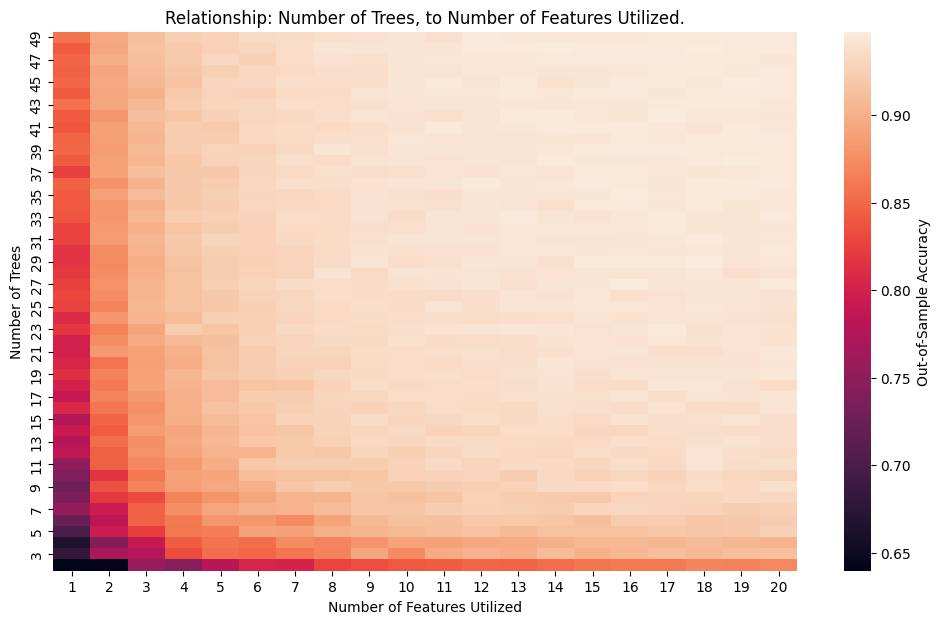

In [9]:
fig, ax = plt.subplots(figsize=(12,7)) 
sns.heatmap(pivot_results.iloc[50:, 0:20], ax=ax, cbar_kws={'label': 'Out-of-Sample Accuracy'})
plt.title('Relationship: Number of Trees, to Number of Features Utilized.')
plt.ylabel('Number of Trees')
plt.xlabel('Number of Features Utilized')
plt.show()

**(b) Could the number of trees be too small for the number of features used?**

Yes, having many diversified models allows the ensemble to reduce the model variance and increase the accuracy. When there are too few trees then this effect can't take place. This is especially true when we limit the number of features per tree. 

**(c) Could the number of trees be too high for the number of observations available?**

Yes, they could be too high. Quoting the [post](https://stats.stackexchange.com/questions/36165/does-the-optimal-number-of-trees-in-a-random-forest-depend-on-the-number-of-pred/36183): "*If the number of observations is large, but the number of trees is too small, then some observations will be predicted only once or even not at all.*". If the number of trees is much larger than the amount of data available then it will start to reduce the number diversified trees. Some trees will be trained on the same data.


## Question 5
**How is out-of-bag accuracy different from stratified k-fold (with shuffling) cross-validation accuracy?**

Out-of-bag accuracy is the mean accuracy of the models trained on data that didn’t form part of the bootstrap sample. Stratified k-fold cross-validation accuracy is the mean accuracy of the models, scored on an out-of-sample data set. The stratified component is a technique to create k-folds, where each fold is representative of the dataset. It is typically used on data that has a class imbalance.

With respect to financial machine learning, because the data isn’t IID and it has a low average uniqueness, a high observation redundancy, bagging models will suffer from trees that are very similar in nature, thus causing the ensemble to be less effective. This problem extends to the out-of-bag accuracy when we sample with replacement as the out-of-bag sample will contain data that is very similar to the observations contained in the bootstrapped sample. It is for this reason that the out-of-bag accuracy is inflated.

The solution de Prado suggests is to use stratified k-fold cross-validation without shuffling, before partitioning. If we were to apply shuffling then the redundant observations would spill over to the various k-folds and our model accuracy would be over-inflated.



---
The following shows how to build ensembles models which take into account average uniqueness, its implementation can be found in the mlfinlab package.

```python
# Snippet 6.2 Three Ways of Setting up a RF
random_forrest = RandomForestClassifier(n_estimators=1000, class_weight='balanced_subsample', criterion='entropy')

base_trees = DecisionTreeClassifier(criterion='entropy', max_features='auto', class_weight='balanced')
bagging_ensemble = BaggingClassifier(base_estimator=base_trees, n_estimators=1000, max_samples=avgU)

rf_1_tree = RandomForestClassifier(n_estimators=1, criterion='entropy', bootstrap=False, class_weight='balanced_subsample')
bagging_ensemble_2 = BaggingClassifier(base_estimator=rf_1_tree, n_estimators=1000, max_samples=avgU, max_features=1.0)
```

